## Import file and other necessary modules

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset from the CSV file
file_path = "Historical Product Demand.csv"
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

### Data analysis

In [35]:
#Check the cardinality.
df.shape

(1048575, 5)

In [36]:
#Checking the data types.
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

### Data cleaning

In [37]:
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio in Dates:  1.0718355863910547


In [38]:
# Extract month and year features
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Encode categorical columns using Label Encoding
label_encoder = LabelEncoder()
df['Product_Code'] = label_encoder.fit_transform(df['Product_Code'])
df['Warehouse'] = label_encoder.fit_transform(df['Warehouse'])
df['Product_Category'] = label_encoder.fit_transform(df['Product_Category'])

# Preprocess the 'Order_Demand' column
df['Order_Demand'] = df['Order_Demand'].str.replace('(', '').str.replace(')', '', regex=False).astype(float)

# Define features and target variable
X = df[['Product_Code', 'Warehouse', 'Product_Category', 'Month', 'Year']]
y = df['Order_Demand']

# Drop rows with missing values
df_cleaned = df.dropna()

# Display the number of rows before and after dropping missing values
print(f"Number of rows before dropping missing values: {len(df)}")
print(f"Number of rows after dropping missing values: {len(df_cleaned)}")

# Define features and target variable after dropping missing values
X_cleaned = df_cleaned[['Product_Code', 'Warehouse', 'Product_Category', 'Month', 'Year']]
y_cleaned = df_cleaned['Order_Demand']

C:\Users\ziyan\AppData\Local\Temp\ipykernel_12196\191225422.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(', '').str.replace(')', '', regex=False).astype(float)


Number of rows before dropping missing values: 1048575
Number of rows after dropping missing values: 1037336


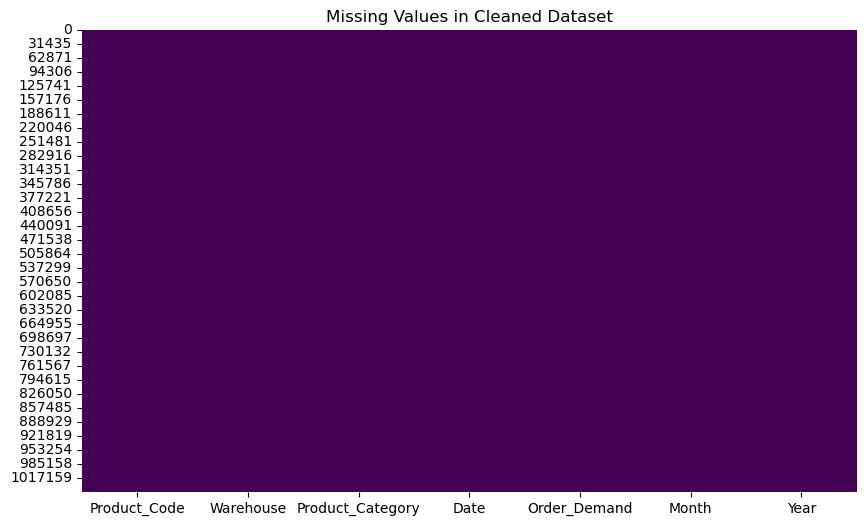

In [39]:
# Display the cleaned dataset in a table format
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Cleaned Dataset')
plt.show()

In [40]:
# Split the cleaned data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Cross-validation
cv_scores = cross_val_score(model, X_cleaned, y_cleaned, cv=5, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores)**0.5
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

Mean Squared Error: 785512654.5582551
R-squared: 0.00778732704051921
Cross-validated RMSE: 28951.117241712218


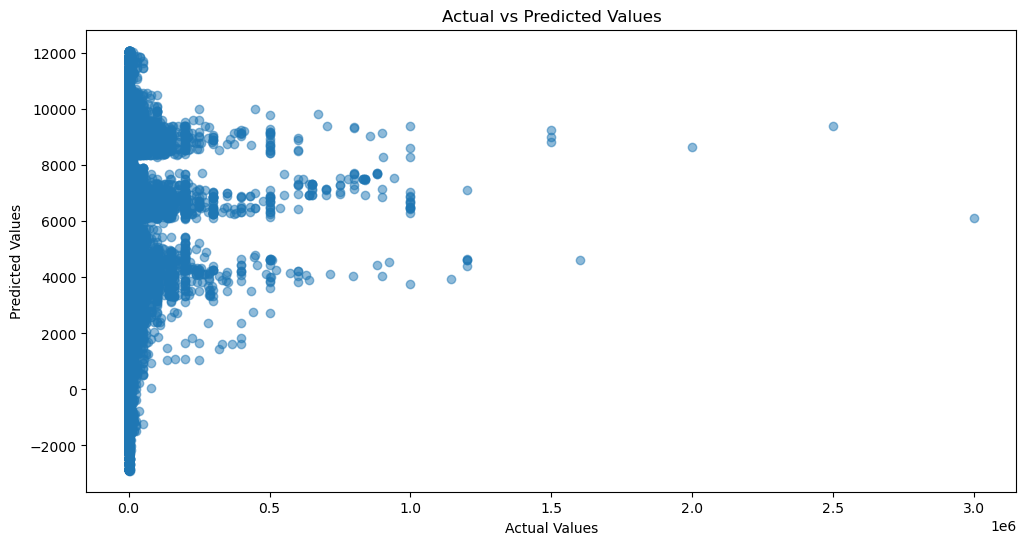

In [41]:
# Visualize predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

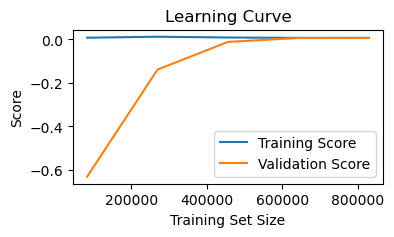

In [42]:
from sklearn.model_selection import learning_curve
import numpy as np


train_sizes, train_scores, test_scores = learning_curve(model, X_cleaned, y_cleaned, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


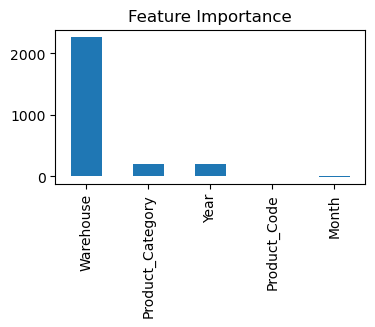

In [43]:
feature_importance = pd.Series(model.coef_, index=X_cleaned.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.show()

## SARIMA Model

In [44]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
#Import the data and parse dates.
df  = pd.read_csv('Historical Product Demand.csv', parse_dates=['Date'])

In [46]:
df.head(5)

Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028 2012-07-27         100 
1  Product_0979    Whse_J     Category_028 2012-01-19         500 
2  Product_0979    Whse_J     Category_028 2012-02-03         500 
3  Product_0979    Whse_J     Category_028 2012-02-09         500 
4  Product_0979    Whse_J     Category_028 2012-03-02         500

In [47]:
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

Product_Code Warehouse Product_Category       Date Order_Demand
75193   Product_0642    Whse_C     Category_019 2011-10-31           3 
121820  Product_0202    Whse_A     Category_007 2011-11-04        (100)
121819  Product_0202    Whse_A     Category_007 2011-11-04        (400)
131028  Product_2143    Whse_S     Category_009 2011-11-18         (25)
131031  Product_0131    Whse_S     Category_021 2011-11-18         (12)
131032  Product_0288    Whse_S     Category_021 2011-11-18         (50)
44450   Product_0980    Whse_A     Category_028 2011-11-18        4000 
131027  Product_2138    Whse_S     Category_009 2011-11-18         (49)
131026  Product_2137    Whse_S     Category_009 2011-11-18         (25)
44795   Product_0965    Whse_A     Category_006 2011-11-18           1

In [48]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

C:\Users\ziyan\AppData\Local\Temp\ipykernel_12196\1566010563.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
C:\Users\ziyan\AppData\Local\Temp\ipykernel_12196\1566010563.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [49]:
df['Date'].min() , df['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

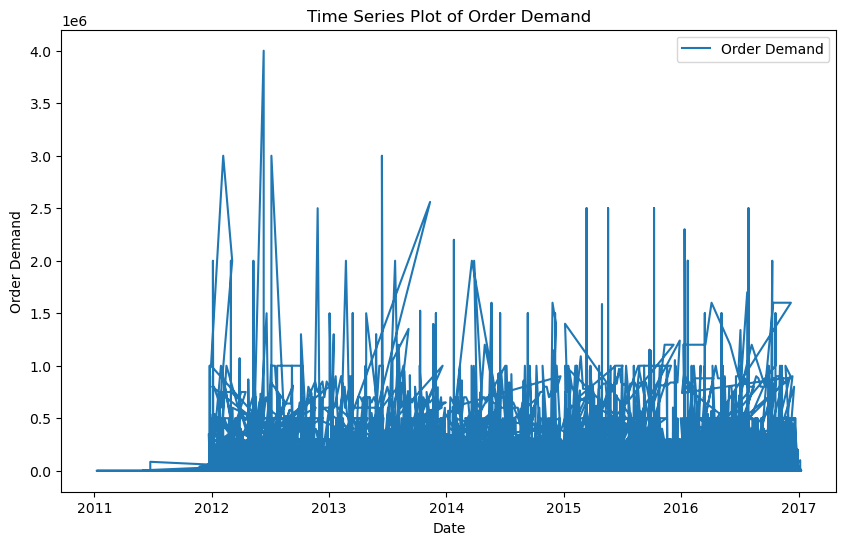

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Order_Demand'], label='Order Demand')
plt.title('Time Series Plot of Order Demand')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend()
plt.show()

In [51]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

C:\Users\ziyan\AppData\Local\Temp\ipykernel_12196\1209714908.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df['Order_Demand'], fit=norm)


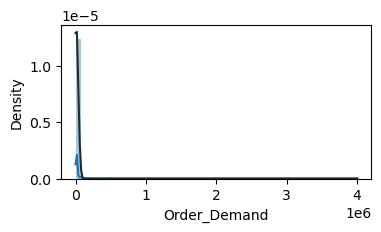

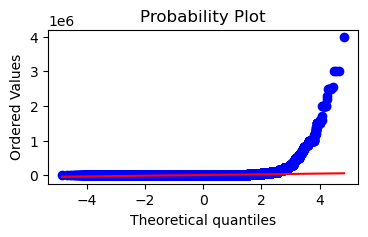

In [52]:
# Checking the skew of data
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [53]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
#This gives us the total orders placed on each day.
print(df)

           Date  Order_Demand
0    2012-01-01             2
1    2012-01-02        680277
2    2012-01-03       1645257
3    2012-01-04       1295861
4    2012-01-05       8941774
...         ...           ...
1676 2016-12-26       3628370
1677 2016-12-27       1674226
1678 2016-12-28       2740302
1679 2016-12-29        530487
1680 2016-12-30        702950

[1681 rows x 2 columns]


In [54]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [55]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()

In [56]:
#Index the date
df = df.set_index('Date')
df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [57]:
y = df['Order_Demand'].resample('MS').mean()

In [58]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(f"Error for parameters {param}, {param_seasonal}: {e}")
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2963.162309676349
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457736
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2987.9309958789995
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.0874878045222
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700684
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345482
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2883.609599551857
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650795
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277828
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759118
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2933.8366043265787
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


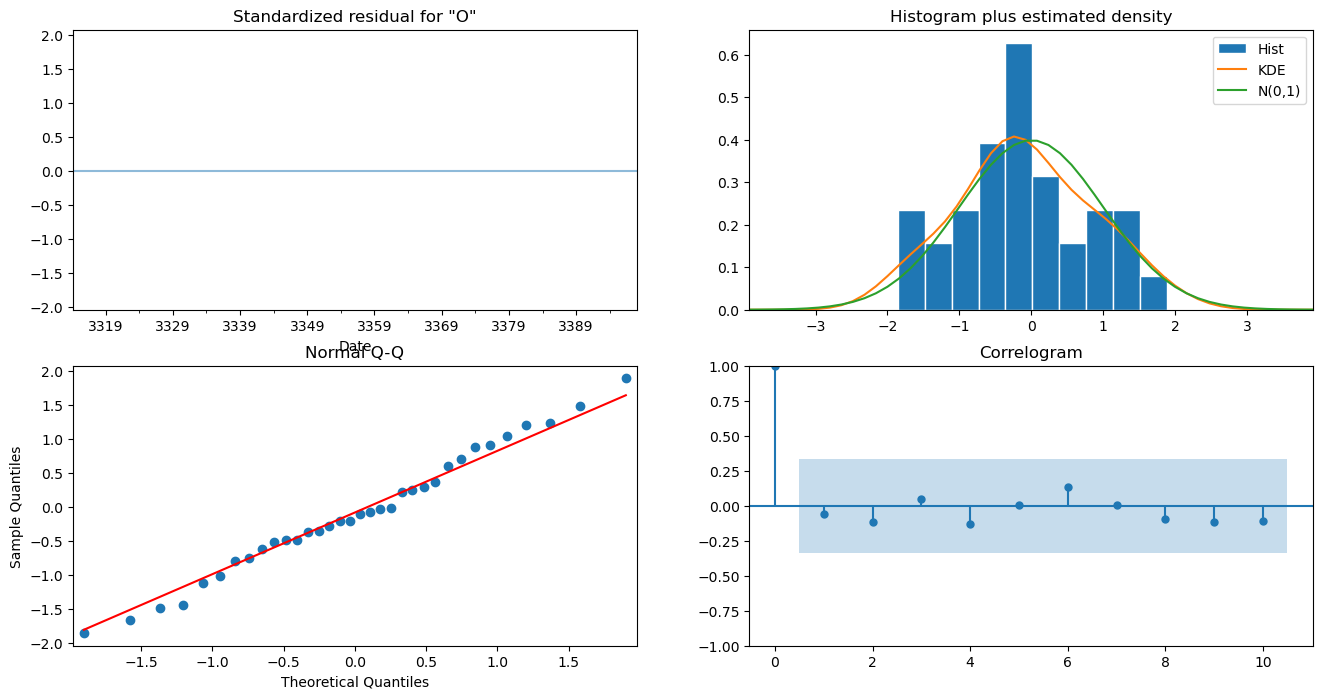

In [60]:
#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

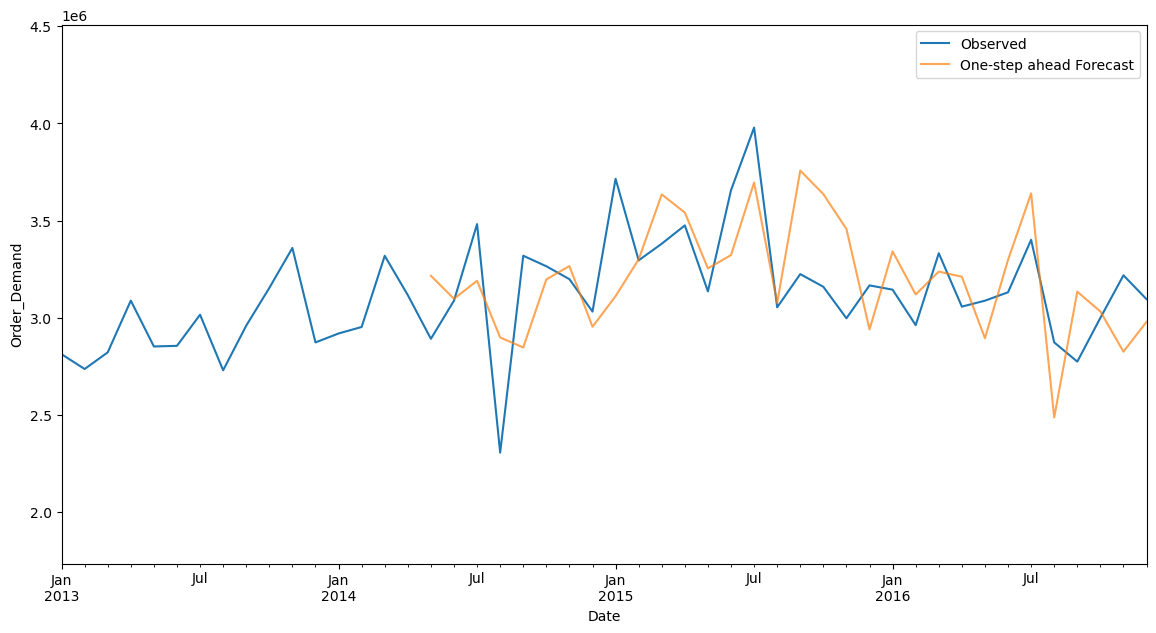

In [61]:
# Get the predictions and confidence interval for those predictions.

# Get the predictions. The forecasts start from the 1st of Jan 2017, and the previous line shows how it fits to the data.
pred_start_date = '2014-05-01'
pred = results.get_prediction(start=pd.to_datetime(pred_start_date), dynamic=False)

# Confidence interval.
pred_ci = pred.conf_int()

# Plotting real and forecasted values.
fig, ax = plt.subplots(figsize=(14, 7))

# Plot observed values
y['2013':].plot(ax=ax, label='Observed')

# Plot one-step ahead forecast
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)

# Fill the confidence interval
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=0.2)

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()

# Show the plot
plt.show()

In [62]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

MSE 55459437820.86


In [63]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 235498.28


In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
import numpy as np

# Extracting relevant data
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]

# Align the indices of y_forecasted and y_truth
y_forecasted = y_forecasted[y_truth.index]

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_truth, y_forecasted)
print('Mean Squared Error: {}'.format(round(mse, 2)))

# Calculating R-squared
r2 = r2_score(y_truth, y_forecasted)
print('R-squared: {}'.format(round(r2, 2)))

Mean Squared Error: 55459437820.86
R-squared: -0.91


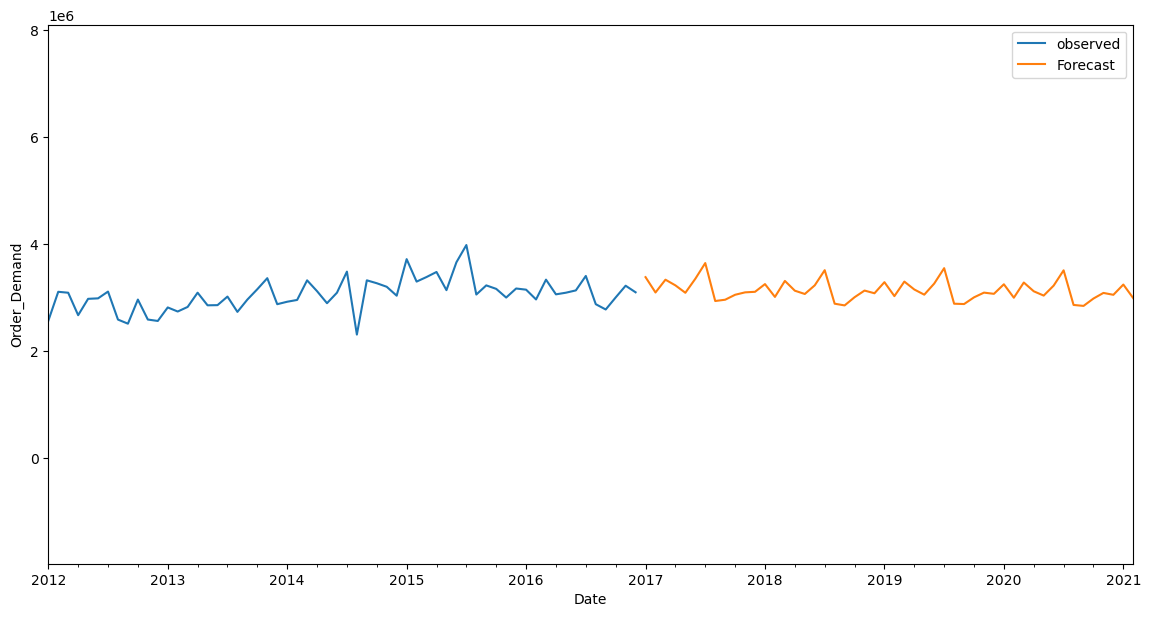

In [65]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [66]:
import plotly.graph_objects as go
import plotly.express as px

# The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

# Plotting observed and forecasted values with confidence interval using Plotly
fig = go.Figure()

# Plot observed values
fig.add_trace(go.Scatter(x=y.index, y=y.values, mode='lines', name='Observed'))

# Plot forecasted values
fig.add_trace(go.Scatter(x=pred_uc.predicted_mean.index, y=pred_uc.predicted_mean.values,
                         mode='lines', name='Forecast', line=dict(color='red')))

# Fill the confidence interval
fig.add_trace(go.Scatter(x=pred_ci.index,
                         y=pred_ci.iloc[:, 0].values,
                         fill='tonexty',
                         mode='lines',
                         line=dict(color='grey'),
                         name='Confidence Interval'))

# Layout settings
fig.update_layout(title='Forecast with Confidence Interval',
                  xaxis_title='Date',
                  yaxis_title='Order_Demand',
                  showlegend=True)

# Show the plot
fig.show()


In [67]:
import plotly.graph_objects as go

# The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

# Create a trace for observed data
trace_observed = go.Scatter(x=y.index, y=y, mode='lines', name='Observed')

# Create a trace for forecasted data
trace_forecast = go.Scatter(x=pred_uc.predicted_mean.index, y=pred_uc.predicted_mean, mode='lines', name='Forecast')

# Create a trace for confidence interval
trace_ci = go.Scatter(x=pred_ci.index,
                     y=pred_ci.iloc[:, 0],
                     fill='tonexty',
                     line=dict(color='rgba(0,100,80,0.2)'),
                     fillcolor='rgba(0,100,80,0.2)',
                     name='Confidence Interval')

# Create layout
layout = go.Layout(title='Forecasting Order Demand',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Order Demand'),
                   showlegend=True)

# Create figure
fig = go.Figure(data=[trace_observed, trace_forecast, trace_ci], layout=layout)

# Show the figure
fig.show()

## Using LSTM Model

In [94]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statistics
import math

#for LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset from the CSV file
file_path = "Historical Product Demand.csv"
data = pd.read_csv(file_path)
data

Product_Code Warehouse Product_Category       Date Order_Demand
0        Product_0993    Whse_J     Category_028  2012/7/27         100 
1        Product_0979    Whse_J     Category_028  2012/1/19         500 
2        Product_0979    Whse_J     Category_028   2012/2/3         500 
3        Product_0979    Whse_J     Category_028   2012/2/9         500 
4        Product_0979    Whse_J     Category_028   2012/3/2         500 
...               ...       ...              ...        ...          ...
1048570  Product_1791    Whse_J     Category_006  2016/4/27        1000 
1048571  Product_1974    Whse_J     Category_006  2016/4/27           1 
1048572  Product_1787    Whse_J     Category_006  2016/4/28        2500 
1048573  Product_0901    Whse_J     Category_023  2016/10/7          50 
1048574  Product_0704    Whse_J     Category_001  2016/6/27           4 

[1048575 rows x 5 columns]

In [73]:
# rename the columns
data.rename(columns = {'Product_Code': 'ProductCode',
                       'Product_Category': 'ProductCategory', 
                       'Order_Demand': 'OrderDemand'}, inplace = True)
data.head()

ProductCode Warehouse ProductCategory       Date OrderDemand
0  Product_0993    Whse_J    Category_028  2012/7/27        100 
1  Product_0979    Whse_J    Category_028  2012/1/19        500 
2  Product_0979    Whse_J    Category_028   2012/2/3        500 
3  Product_0979    Whse_J    Category_028   2012/2/9        500 
4  Product_0979    Whse_J    Category_028   2012/3/2        500

In [74]:
data.dropna(inplace=True)

# check the null data again
data.isnull().sum()

ProductCode        0
Warehouse          0
ProductCategory    0
Date               0
OrderDemand        0
dtype: int64

In [76]:
# sort the data according to date column
data.sort_values('Date', ignore_index=True, inplace=True)
data.head()

ProductCode Warehouse ProductCategory        Date OrderDemand
0  Product_0965    Whse_A    Category_006    2011/1/8          2 
1  Product_0412    Whse_S    Category_007  2011/10/20         (2)
2  Product_0125    Whse_S    Category_011  2011/10/20         (2)
3  Product_0642    Whse_C    Category_019  2011/10/31          3 
4  Product_2137    Whse_S    Category_009  2011/11/18        (25)

In [77]:
# there are () int the OrderDemand column and we need to remove them
data['OrderDemand'] = data['OrderDemand'].str.replace('(',"")
data['OrderDemand'] = data['OrderDemand'].str.replace(')',"")

# change the dtype as int64
data['OrderDemand'] = data['OrderDemand'].astype('int64')

C:\Users\ziyan\AppData\Local\Temp\ipykernel_12196\2313791127.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\ziyan\AppData\Local\Temp\ipykernel_12196\2313791127.py:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [79]:
# convert the 'Date' column to datetime format
data['Date']= pd.to_datetime(data['Date'])

# create Year, Month, Day columns
data['Year'] = data["Date"].dt.year
data['Month'] = data["Date"].dt.month
data['Day'] = data["Date"].dt.day

In [81]:
# Using data between 2012-01-01 and 2016-12-31
df = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)
df = df.groupby('Date')['OrderDemand'].sum().reset_index()
df

Date  OrderDemand
0    2012-01-01            2
1    2012-01-02       680277
2    2012-01-03      1645257
3    2012-01-04      1295861
4    2012-01-05      8941774
...         ...          ...
1676 2016-12-26      3628370
1677 2016-12-27      1674226
1678 2016-12-28      2740302
1679 2016-12-29       530487
1680 2016-12-30       702950

[1681 rows x 2 columns]

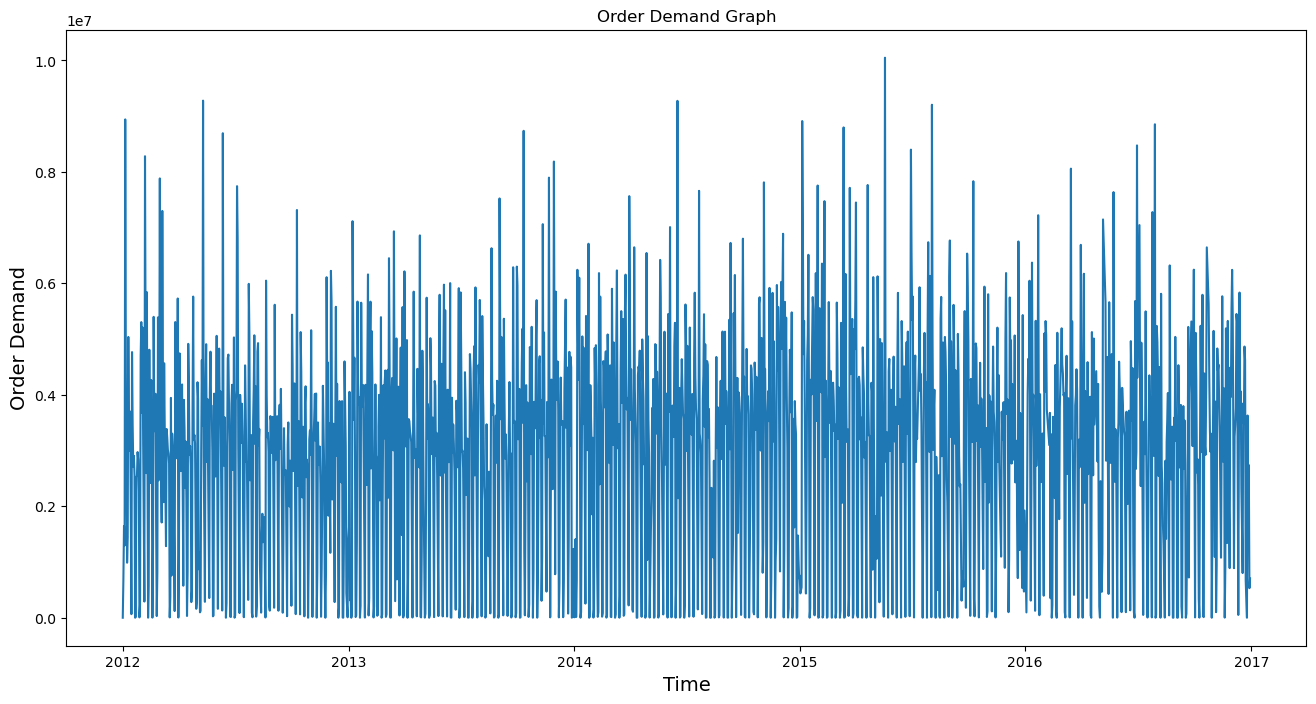

In [82]:
# Visualize the order demand as time series
plt.figure(figsize=(16, 8))
plt.title("Order Demand Graph")
plt.plot(df["Date"], df["OrderDemand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [84]:
import math
# Create new data with only the "OrderDemand" column
orderD = df.filter(["OrderDemand"])
# Convert the dataframe to a np array
orderD_array = orderD.values
# See the train data len
train_close_len = math.ceil(len(orderD_array) * 0.8)
train_close_len

1345

In [86]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(orderD_array)
scaled_data

array([[1.99031453e-07],
       [6.76982600e-02],
       [1.63728946e-01],
       ...,
       [2.72703145e-01],
       [5.27917993e-02],
       [6.99545800e-02]])

In [87]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([1.99031453e-07, 6.76982600e-02, 1.63728946e-01, 1.28958549e-01,
       8.89847137e-01, 4.36947184e-01, 9.82368500e-02, 1.43570443e-01,
       5.01388891e-01, 3.30568853e-01, 2.98325061e-01, 3.68113549e-01,
       6.39388544e-03, 4.74326585e-01, 3.44696702e-01, 2.69870529e-01,
       2.89035666e-01, 2.55127374e-01, 1.99031453e-05, 1.34953277e-03,
       2.51593073e-01, 2.53474816e-01, 2.95791390e-01, 2.81800375e-01,
       2.26411613e-01, 6.16997505e-04, 2.32949398e-02, 4.68048834e-01,
       5.27871021e-01, 3.66383269e-01, 5.18157490e-01, 3.13818067e-01,
       2.88706070e-02, 8.24073013e-01, 4.73426465e-01, 2.58256546e-01,
       5.81354156e-01, 3.14602052e-01, 9.95157266e-05, 5.74927232e-02,
       4.78518585e-01, 2.40411486e-01, 3.48965828e-01, 4.24549316e-01,
       2.88825090e-01, 1.69176735e-04, 1.26577138e-01, 5.37255155e-01,
       3.60979068e-01, 3.33127004e-01, 3.99856478e-01, 1.72541561e-01,
       2.98547180e-03, 8.14840741e-02, 5.36301397e-01, 2.45390755e-01,
     

In [88]:
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [89]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1285, 60, 1)

In [90]:
# create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
# create X_test and y_test
X_test = []
y_test = df.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [91]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [95]:
from keras.models import Sequential
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

In [96]:
# compile the LSTM model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [97]:
# train the LSTM model
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
13/13 [==============================] - 31s 2s/step - loss: 0.0684 - mae: 0.2178
Epoch 2/3
13/13 [==============================] - 23s 2s/step - loss: 0.0436 - mae: 0.1693
Epoch 3/3
13/13 [==============================] - 22s 2s/step - loss: 0.0412 - mae: 0.1657


In [98]:
# predict with LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 5s 419ms/step


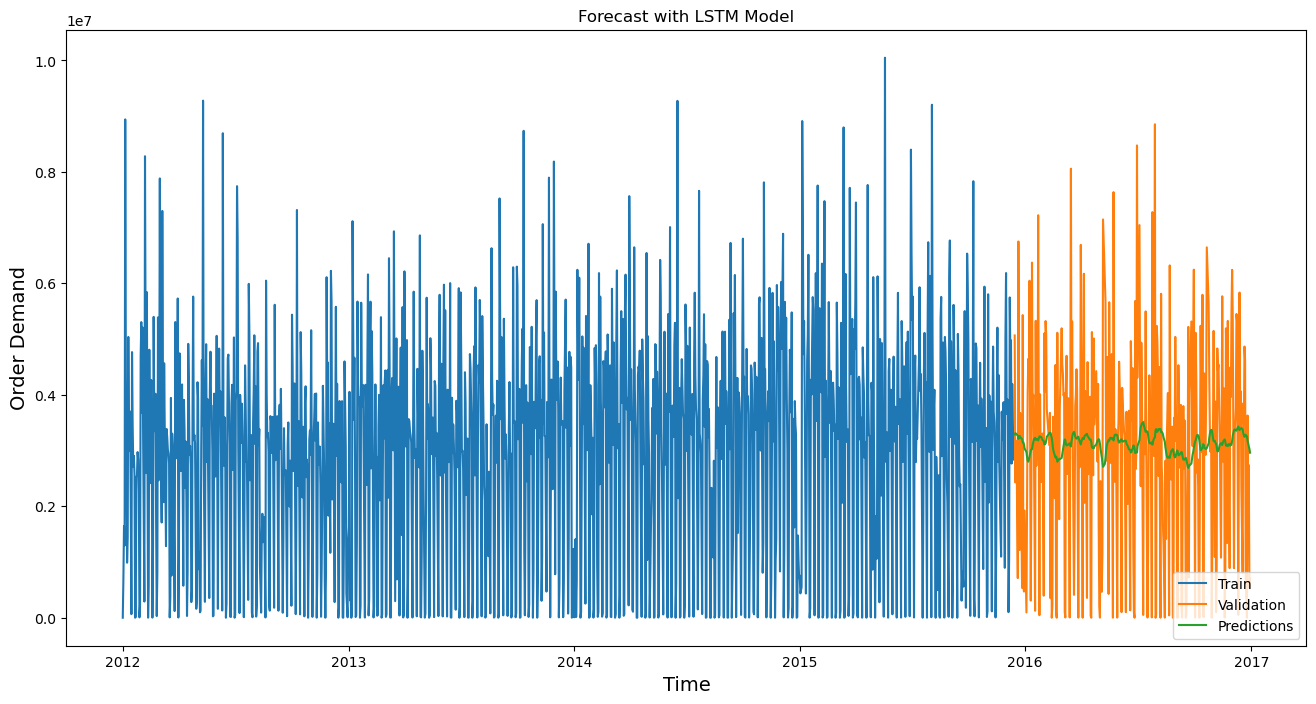

In [99]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

### Building optimized LSTM

In [100]:
# change the parameters of first LSTM model and build the Optimized LSTM Model
optimized_model = Sequential()

optimized_model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

optimized_model.add(LSTM(256, activation='relu', return_sequences=False))

optimized_model.add(Dense(128))

optimized_model.add(Dense(64))

optimized_model.add(Dense(32))

optimized_model.add(Dense(1))

In [101]:
# compile the model
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [102]:
# train the optimized model
optimized_model.fit(X_train, y_train, 
          batch_size=32, 
          epochs=20, 
          verbose=1)

Epoch 1/20
41/41 [==============================] - 54s 1s/step - loss: 0.0436 - mae: 0.1678
Epoch 2/20
41/41 [==============================] - 41s 1s/step - loss: 0.0409 - mae: 0.1650
Epoch 3/20
41/41 [==============================] - 42s 1s/step - loss: 0.0401 - mae: 0.1615
Epoch 4/20
41/41 [==============================] - 41s 999ms/step - loss: 0.0413 - mae: 0.1643
Epoch 5/20
41/41 [==============================] - 42s 1s/step - loss: 0.0385 - mae: 0.1597
Epoch 6/20
41/41 [==============================] - 42s 1s/step - loss: 0.0371 - mae: 0.1555
Epoch 7/20
41/41 [==============================] - 42s 1s/step - loss: 0.0359 - mae: 0.1526
Epoch 8/20
41/41 [==============================] - 43s 1s/step - loss: 0.0360 - mae: 0.1531
Epoch 9/20
41/41 [==============================] - 42s 1s/step - loss: 0.0334 - mae: 0.1471
Epoch 10/20
41/41 [==============================] - 42s 1s/step - loss: 0.0319 - mae: 0.1432
Epoch 11/20
41/41 [==============================] - 42s 1s/step -

In [103]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

11/11 [==============================] - 4s 346ms/step


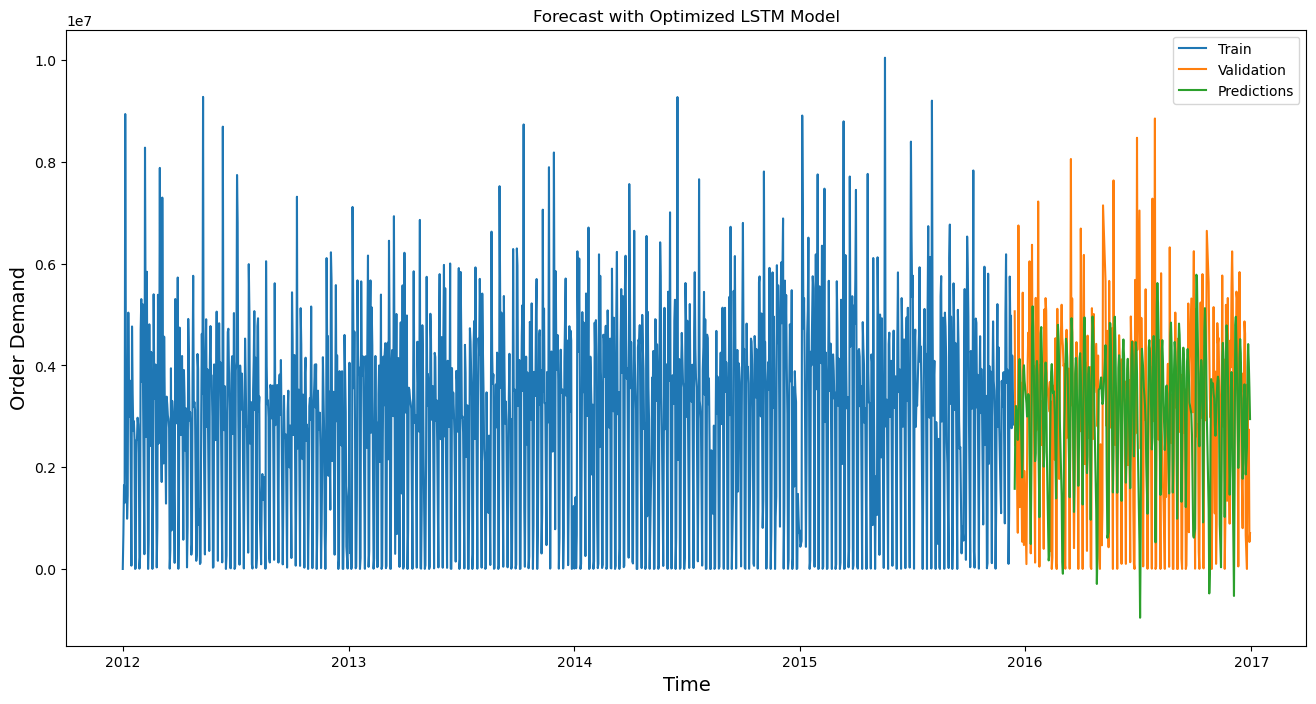

In [104]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="upper right")
plt.show()